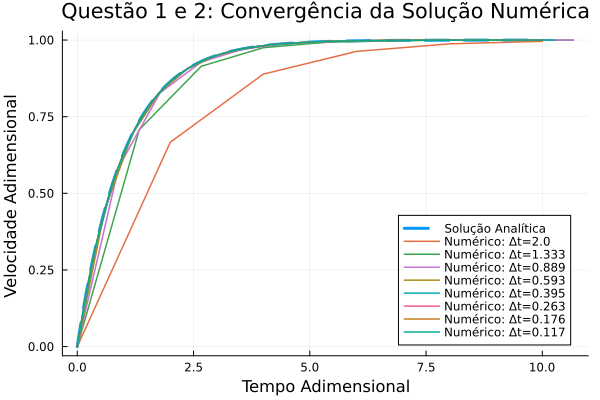

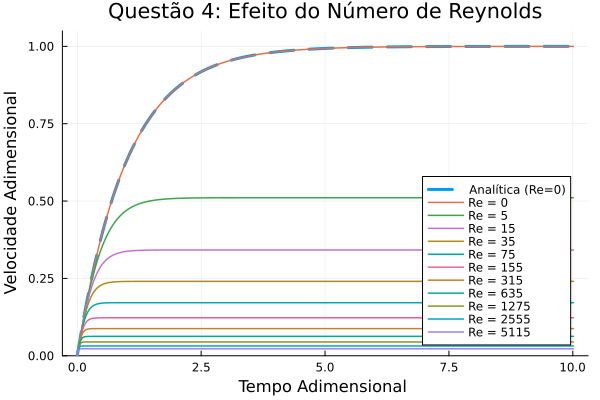

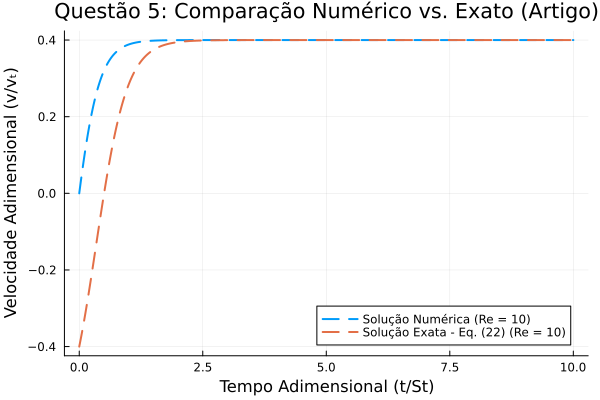

In [1]:
# -*- coding: utf-8 -*-

# Carrega a biblioteca para fazer os gráficos
using Plots

# --- Parâmetros Globais da Simulação ---
const T_MAXIMO = 10
const St = 1.0


# Solucionador genérico de EDOs usando Runge-Kutta de 4ª Ordem
function resolver_rk(f_edo, v_inicial, t_inicial, t_maximo, Δt)
    v_atual, t_atual = v_inicial, t_inicial
    passos_tempo, passos_velocidade = [], []

    while t_atual < t_maximo
        push!(passos_velocidade, v_atual)
        push!(passos_tempo, t_atual)

        k1 = f_edo(t_atual, v_atual)
        k2 = f_edo(t_atual + Δt/2, v_atual + k1*Δt/2)
        k3 = f_edo(t_atual + Δt/2, v_atual + k2*Δt/2)
        k4 = f_edo(t_atual + Δt/2, v_atual + k3*Δt)
        v_proximo = v_atual + Δt * (k1 + 2*k2 + 2*k3 + k4) / 6

        t_atual += Δt
        v_atual = v_proximo
    end

    push!(passos_velocidade, v_atual); push!(passos_tempo, t_atual)
    return passos_tempo, passos_velocidade
end



# Define a equação diferencial para o arrasto de Stokes (linear)
f_stokes(t, v) = (-v + 1) / St

# Calcula a solução analítica para comparação
tempo_analitico = range(0, T_MAXIMO, length=1000)
velocidade_analitica = @. 1 - ℯ^(-tempo_analitico / St)

# Cria o gráfico inicial com a solução analítica
grafico_stokes = plot(tempo_analitico, velocidade_analitica,
    ylabel="Velocidade Adimensional ",
    xlabel="Tempo Adimensional",
    label="Solução Analítica",
    linewidth=3, linestyle=:dash, legend=:bottomright,
    title="Questão 1 e 2: Convergência da Solução Numérica"
)

# Loop para calcular a solução numérica com diferentes passos de tempo (Δt)
for i in 0:7
    Δt = 2 * 1.5^(-i)
    tempo_numerico, velocidade_numerica = resolver_rk(f_stokes, 0.0, 0.0, T_MAXIMO, Δt)
    plot!(grafico_stokes, tempo_numerico, velocidade_numerica,
        label="Numérico: Δt=$(round(Δt, digits=3))",
        linewidth=1.5
    )
end

display(grafico_stokes)



# Define a equação com o termo de arrasto quadrático
f_quadratica(t, v, Re) = (-v - (3/8) * Re * v^2 + 1) / St

# Cria um novo gráfico, começando com a solução de Re=0 como referência
grafico_reynolds = plot(tempo_analitico, velocidade_analitica,
    ylabel="Velocidade Adimensional",
    xlabel="Tempo Adimensional ",
    label="Analítica (Re=0)",
    linewidth=3, linestyle=:dash, ylims=(0, 1.05), legend=:bottomright,
    title="Questão 4: Efeito do Número de Reynolds"
)

# Loop para calcular a solução numérica para vários valores de Re
Δt_fixo = 0.01
for i in 0:10
    Re = 5.0 * 2^(i) - 5.0
    f_com_re(t, v) = f_quadratica(t, v, Re)
    tempo_numerico, velocidade_numerica = resolver_rk(f_com_re, 0.0, 0.0, T_MAXIMO, Δt_fixo)

    plot!(grafico_reynolds, tempo_numerico, velocidade_numerica,
        label="Re = $(round(Int, Re))",
        linewidth=1.5
    )
end

display(grafico_reynolds)


function velocidade_exata_oseen(tempo_vetor, Re, St, χ)
    # Parâmetros auxiliares definidos no artigo
    ε = (3/8) * Re
    A = 1 + χ/2

    # 1. Primeiro, calcule a velocidade terminal (v_t) usando a Eq. (18)
    # v_t é a solução de -v_t - ε*v_t^2 + 1 = 0
    if Re == 0
        v_t = 1.0
    else
        v_t = (-8 + sqrt(64 +96*Re)) / (6*Re) # Eq. (18)
    end

    # 2. Agora, calcule a velocidade v(t) usando a Eq. (22)


     v_exata = @. v_t * (1 +( 1 + 2*ε*v_t) / ((1 - ε*v_t) * exp((1 + 2*ε*v_t) * tempo_vetor / A) - ε*v_t))

    return v_exata
end

#Parâmetros de escolha
χ = 1000/2000 # Razão entre a massa específica do fluido e da partícula
Re_para_comparar = 10

# 1. Pega a sua solução numérica (já calculada na célula anterior)
f_com_re_comp(t, v) = f_quadratica(t, v, Re_para_comparar)
tempo_numerico_comp, velocidade_numerica_comp = resolver_rk(f_com_re_comp, 0.0, 0.0, T_MAXIMO, 0.001)

# 2. Calcula a solução exata do artigo para o mesmo Re
tempo_exato = range(0, T_MAXIMO, length=1000)
velocidade_exata = velocidade_exata_oseen(tempo_exato, Re_para_comparar, St, χ)

# 3. Plota as duas juntas
grafico_comparativo = plot(tempo_numerico_comp, velocidade_numerica_comp,
    label="Solução Numérica (Re = $(Re_para_comparar))",
    linewidth=2,
    linestyle=:dash,
    title="Questão 5: Comparação Numérico vs. Exato (Artigo)",
    xlabel="Tempo Adimensional (t/St)",
    ylabel="Velocidade Adimensional (v/vₜ)",
    legend=:bottomright
)

plot!(grafico_comparativo, tempo_exato, velocidade_exata,
    label="Solução Exata - Eq. (22) (Re = $(Re_para_comparar))",
    linewidth=2,
    linestyle = :dash
)

display(grafico_comparativo)
